たかしの秘密の実験室(番外編:ETL 1/2)

《概要》<br>
http://etlcdb.db.aist.go.jp/<br/>
上記サイトのDownLoadから申請を出し、返ってきたメールのリンクから文字データを取得します。その後、適当なディレクトリに解凍します。<br>
『root_path』と『extract_path』を環境に合わせて変更してください。<br>
<br>
《参考サイト》<br>
 https://qiita.com/kcrt/items/a7f0582a91d6599d164d<br>
<br>
《実行結果(result sample)》<br>
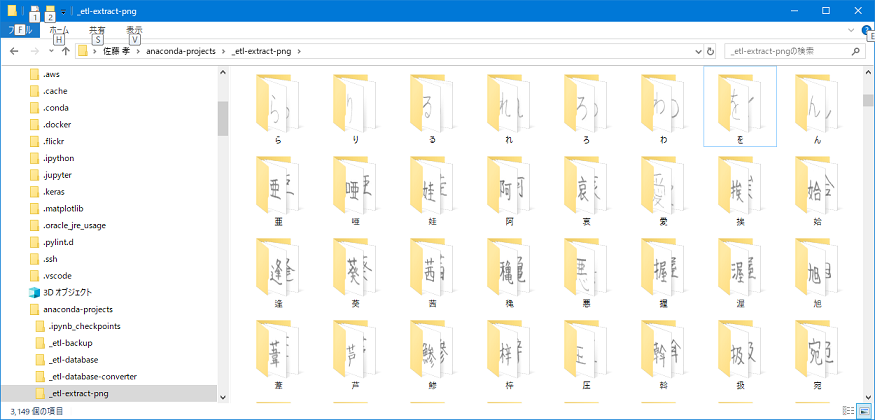

In [ ]:
%config IPCompleter.greedy=True

In [ ]:
import struct          # バイト列をパックされたバイナリデータとして解釈する
import numpy as np
import os
import sys
from PIL import Image

In [ ]:
# ★解凍したETLのディレクトリを入れたパス
root_path = "../_etl-database"

# ★ETLのファイルを画像化したものを出力するディレクトリ
# ※ただし、画像の中には特殊記号が含まれているため、予期しないディレクトリに展開されるものもあります
extract_path = "../_etl-extract-png"

In [ ]:
def get_path_list(root_path):
    path_lists = ([os.path.join(root, file).replace(os.sep, '/') for root, dirs, files in os.walk(root_path)
                   for file in files
                   if not file.upper().endswith('INFO')
                  ])
    return path_lists

In [ ]:
def convert_to_png(file_path):
    # HACK: JISコードのため別プログラムで行う
    # HACK: 2でエラー発生したので、2,3,4,5は除外
    if (file_path.find("ETL8B") > -1 or
        file_path.find("ETL8G") > -1 or
        file_path.find("ETL9B") > -1 or
        file_path.find("ETL9G") > -1 or
        file_path.find("ETL2") > -1 or
        file_path.find("ETL3") > -1 or
        file_path.find("ETL4") > -1 or
        file_path.find("ETL5") > -1): return

    RECORD_SIZE = 2052
    i = 0
    print("Reading {}".format(file_path))
    with open(file_path, 'rb') as f:
        while True:
            s = f.read(RECORD_SIZE)
            if s is None or len(s) < RECORD_SIZE:
                break
            r = struct.unpack(">H2sHBBBBBBIHHHHBBBBHH2016s4x", s)
            img = Image.frombytes('F', (64, 63), r[20], 'bit', (4, 0))
            img = img.convert('L')
            img = img.point(lambda x: 255 - (x << 4))
            i = i + 1
            dir_name = r[1].decode('utf-8')
            
            # ★コロン、スラッシュなど、Windowsでディレクトリ名に出来ないものも追加したほうが良いかも
            # ★それか、全角文字に変換する
            dir_name = dir_name.replace('\0', '')
            dir_name = dir_name.replace(' ', '')
            dir_name = dir_name.replace('\\', 'YEN')
            dir_name = dir_name.replace('+', 'PLUS')
            dir_name = dir_name.replace('-', 'MINUS')
            dir_name = dir_name.replace('*', 'ASTERISK')
            
            file_name = os.path.basename(file_path)
            try:
                os.makedirs(f"{extract_path}/{dir_name}")
            except:
                pass
            #imagefile = f"{file_path}_{i:0>6}.png"
            imagefile = f"{extract_path}/{dir_name}/{file_name}_{i:0>6}.png"
            #imagefile = f"extract/{dirname}/{filename}_{i:0>6}.png"
            #print(imagefile)
            img.save(imagefile)

In [ ]:
def main():
    for file_path in get_path_list(root_path):
        convert_to_png(file_path)
        
        #try:
            #convert_to_png(file_path)
        #except:
            #print("☆★☆{}のファイル読み込み中にエラー発生".format(file_path))
            #import traceback
            #traceback.print_exc()

In [ ]:
if __name__ == "__main__":
    main()